In [11]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import modgp
import GPflow

In [12]:
#%% 
def logistic(x):
    return 1./(1+ np.exp(-x))

In [13]:
#%%
X = np.linspace(0, 1, 2000).reshape(-1, 1)
k1 = GPflow.kernels.Matern52(input_dim=1, lengthscales=1.0, variance=10)
k2 = GPflow.kernels.Matern52(input_dim=1, lengthscales=0.1, variance=10)

frec = 27.50 #A0
k_i = GPflow.kernels.Cosine(input_dim = 1, variance=1.0,  lengthscales=1./(2*np.pi*frec))
k_j = GPflow.kernels.Cosine(input_dim = 1, variance=0.5,  lengthscales=1./(2*2*np.pi*frec))
k_l = GPflow.kernels.Cosine(input_dim = 1, variance=0.25, lengthscales=1./(3*2*np.pi*frec))
k3 = k_i + k_j + k_l



frec = 20.60 #E0
k_a = GPflow.kernels.Cosine(input_dim = 1, variance=1.0,  lengthscales=1./(2*np.pi*frec))
k_b = GPflow.kernels.Cosine(input_dim = 1, variance=0.5,  lengthscales=1./(2*2*np.pi*frec))
k_c = GPflow.kernels.Cosine(input_dim = 1, variance=0.25, lengthscales=1./(3*2*np.pi*frec))
k1 = k_a + k_b + k_c

In [14]:
#%% calculate cov matrices
K1 = k1.compute_K_symm(X)
K2 = k2.compute_K_symm(X)
K3 = k3.compute_K_symm(X)

In [15]:
#%% sample f and g, transform g and generate the "observed" data y.
noise_var = 0.001
np.random.seed(1)
f = np.random.multivariate_normal(np.zeros(X.shape[0]), K3).reshape(-1, 1)
g = np.random.multivariate_normal(np.zeros(X.shape[0]), K2).reshape(-1, 1)
h = np.random.multivariate_normal(np.zeros(X.shape[0]), K1).reshape(-1, 1)
mean = f * logistic(g) + h
y = mean + np.random.randn(*mean.shape) * np.sqrt(noise_var)

/home/paad/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: covariance is not positive-semidefinite.
/home/paad/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: covariance is not positive-semidefinite.


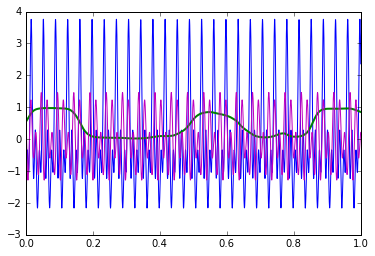

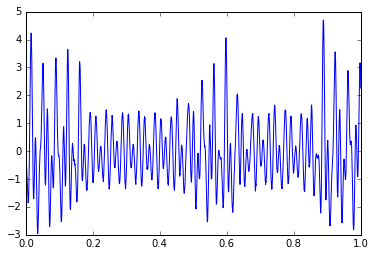

In [16]:
#%% plot the latent functions f(t) and \sigma(g(t)), plot the observed variable y(t)
plt.figure()
plt.plot(X, f, 'b', lw=1)

#plt.figure()
plt.plot(X, logistic(g), 'g', lw=2)

#plt.figure()
plt.plot(X, h, 'm', lw=1)

#%%
plt.figure()
plt.plot(X, y, 'b')

In [17]:
#%% generate model object
Z = X[::8].copy() # copy inducting points from input vector X
m = modgp.ModGP(X, y, k3, k2, k1, Z) # X -> input variable, y -> observed data, k1,k2 -> kernels, Z -> inducting points

In [24]:
#%% keep model parameters fixed.
m.kern1.fixed = True
m.kern2.fixed = True
m.kern3.fixed = True
m.likelihood.noise_var = noise_var
m.likelihood.noise_var.fixed = True

#%% optimize the approximated distributions over f(t) and g(t).
m.optimize(disp=1,maxiter=2500)

      fun: -3875.8324609002493
 hess_inv: <188250x188250 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.04613281, -0.        , -0.        , ..., -0.1790059 ,
       -0.10329626,  0.09792656])
  message: 'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 1128
      nit: 1001
   status: 1
  success: False
        x: array([  1.99218135e-03,   0.00000000e+00,   0.00000000e+00, ...,
        -8.83805102e-01,   5.10279965e-02,   3.67652258e+00])

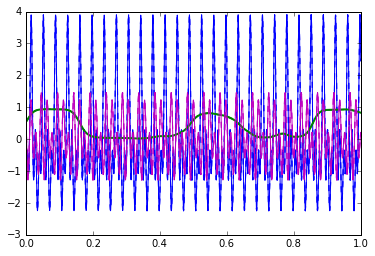

In [34]:
#% evaluate predictions
mu, var = m.predict_f(X)
plt.figure()
plt.plot(X, mu, 'b')
plt.plot(X, mu + 2*np.sqrt(var), 'b--')
plt.plot(X, mu - 2*np.sqrt(var), 'b--')

mu, var = m.predict_g(X)
#plt.figure()
plt.plot(X, logistic(mu), 'g', lw=2)
plt.plot(X, logistic(mu + 2*np.sqrt(var)), 'g--')
plt.plot(X, logistic(mu - 2*np.sqrt(var)), 'g--')

mu, var = m.predict_h(X)
#plt.figure()
plt.plot(X, mu, 'm', lw=1)
plt.plot(X, mu + 2*np.sqrt(var), 'm--')
plt.plot(X, mu - 2*np.sqrt(var), 'm--')

#%%

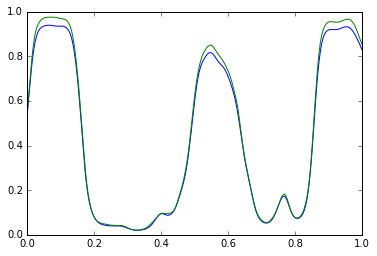

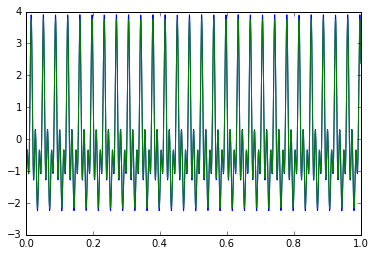

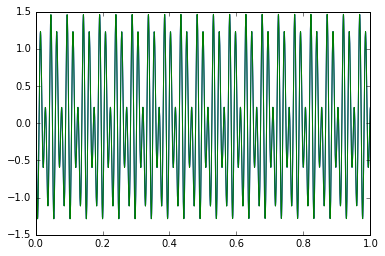

In [33]:
mu, var = m.predict_g(X)
plt.figure()
plt.plot(X, logistic(mu), 'b')
plt.plot(X, logistic(g), 'g')

mu, var = m.predict_f(X)
plt.figure()
plt.plot(X, mu, 'b')
plt.plot(X, f, 'g')

mu, var = m.predict_h(X)
plt.figure()
plt.plot(X, mu, 'b')
plt.plot(X, h, 'g')